In [1]:
import os
import cv2
import keras
import numpy as np
from tqdm import tqdm
from keras import layers
from keras import regularizers
from keras import initializers
from skimage.io import imread
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

Using TensorFlow backend.


In [2]:
img_size = (512, 512)
num_classes = 2
batch_size = 1
image_extention = '.png'
base_data_path = 'road_segmentation_ideal/'
train_data_path = base_data_path + 'training/'
test_data_path = base_data_path + 'testing/'
train_input_data_path = train_data_path + 'input/'
train_output_data_path = train_data_path + 'output/'
test_input_data_path = test_data_path + 'input/'
test_output_data_path = test_data_path + 'output/'

In [3]:
train_input = set([x.replace(image_extention, '') for x in os.listdir(train_input_data_path) if image_extention in x ])
train_output = set([x.replace(image_extention, '') for x in os.listdir(train_output_data_path) if image_extention in x ])
test_input = set([x.replace(image_extention, '') for x in os.listdir(test_input_data_path) if image_extention in x ])
test_output = set([x.replace(image_extention, '') for x in os.listdir(test_output_data_path) if image_extention in x ])

In [4]:
training_data = [x for x in train_input if x in train_output]

In [5]:
image_with_problem = set()
if os.path.exists("image_with_problem.txt"):
    with open("image_with_problem.txt") as f:
        image_with_problem.update(f.readline().split(','))
else:
    for x in tqdm(training_data):
        img = cv2.imread(train_input_data_path + x + image_extention)
        mask = img==(255,255,255)
        mask = mask[:,:,0] & mask[:,:,1] & mask[:,:,2]
        blank_pixel_ratio = np.sum(mask) / (1500*1500)
        if blank_pixel_ratio > 0.02:
            image_with_problem.add(x)
    with open("image_with_problem.txt",'w') as f:
        f.write(",".join(image_with_problem))

  0%|          | 0/84 [00:00<?, ?it/s]

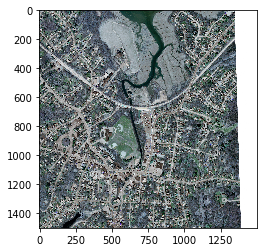

  1%|          | 1/84 [00:00<00:31,  2.67it/s]

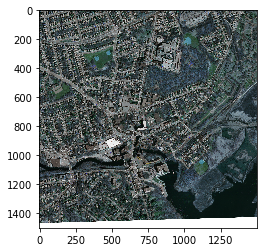

  2%|▏         | 2/84 [00:00<00:30,  2.68it/s]

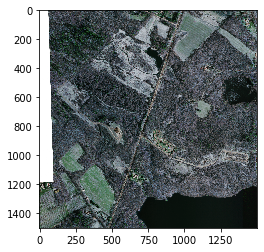

  4%|▎         | 3/84 [00:01<00:29,  2.70it/s]

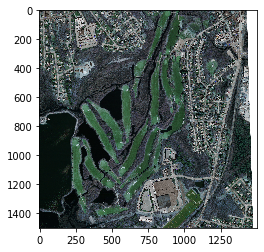

  5%|▍         | 4/84 [00:01<00:29,  2.70it/s]

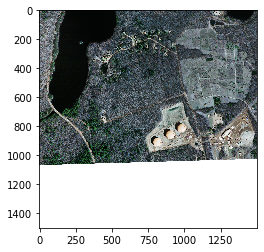

  6%|▌         | 5/84 [00:01<00:28,  2.76it/s]

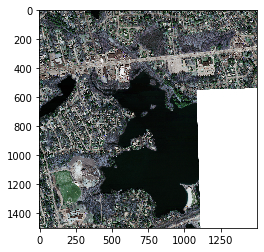

  7%|▋         | 6/84 [00:02<00:28,  2.75it/s]

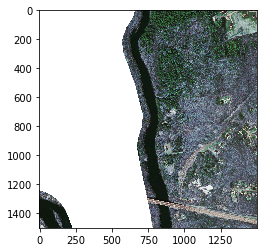

  7%|▋         | 6/84 [00:02<00:32,  2.38it/s]


In [6]:
i = 0
for x in tqdm(image_with_problem):
    img = cv2.imread(train_input_data_path + x + image_extention)
    plt.imshow(img)
    plt.show()
    if i > 5:
        break
    i += 1

In [7]:
training_data = [x for x in training_data if x not in image_with_problem]
training_input_data = [train_input_data_path + x + image_extention for x in training_data]
training_output_data = [train_output_data_path + x + image_extention for x in training_data]
print("Training data " + str(len(training_input_data)))
for i in range(10):
    print(training_input_data[i], training_output_data[i])

Training data 720
road_segmentation_ideal/training/input/img-702.png road_segmentation_ideal/training/output/img-702.png
road_segmentation_ideal/training/input/img-414.png road_segmentation_ideal/training/output/img-414.png
road_segmentation_ideal/training/input/img-930.png road_segmentation_ideal/training/output/img-930.png
road_segmentation_ideal/training/input/img-635.png road_segmentation_ideal/training/output/img-635.png
road_segmentation_ideal/training/input/img-480.png road_segmentation_ideal/training/output/img-480.png
road_segmentation_ideal/training/input/img-832.png road_segmentation_ideal/training/output/img-832.png
road_segmentation_ideal/training/input/img-516.png road_segmentation_ideal/training/output/img-516.png
road_segmentation_ideal/training/input/img-915.png road_segmentation_ideal/training/output/img-915.png
road_segmentation_ideal/training/input/img-371.png road_segmentation_ideal/training/output/img-371.png
road_segmentation_ideal/training/input/img-857.png road

In [8]:
testing_data = [x for x in test_input if x in test_output]
testing_input_data = [test_input_data_path + x + image_extention for x in testing_data]
testing_output_data = [test_output_data_path + x + image_extention for x in testing_data]
print("Testing data " + str(len(testing_input_data)))
for i in range(10):
    print(testing_input_data[i], testing_output_data[i])

Testing data 13
road_segmentation_ideal/testing/input/img-4.png road_segmentation_ideal/testing/output/img-4.png
road_segmentation_ideal/testing/input/img-1.png road_segmentation_ideal/testing/output/img-1.png
road_segmentation_ideal/testing/input/img-13.png road_segmentation_ideal/testing/output/img-13.png
road_segmentation_ideal/testing/input/img-5.png road_segmentation_ideal/testing/output/img-5.png
road_segmentation_ideal/testing/input/img-12.png road_segmentation_ideal/testing/output/img-12.png
road_segmentation_ideal/testing/input/img-10.png road_segmentation_ideal/testing/output/img-10.png
road_segmentation_ideal/testing/input/img-6.png road_segmentation_ideal/testing/output/img-6.png
road_segmentation_ideal/testing/input/img-11.png road_segmentation_ideal/testing/output/img-11.png
road_segmentation_ideal/testing/input/img-2.png road_segmentation_ideal/testing/output/img-2.png
road_segmentation_ideal/testing/input/img-7.png road_segmentation_ideal/testing/output/img-7.png


In [9]:
def splitImage(img, img_size):
    height = img.shape[0]
    width = img.shape[1]
    midHeight = int(height/2)
    midWidth = int(width/2)
    midImgSize = [int(img_size[0]/2), int(img_size[1]/2)]
    topLeft = img[0:img_size[0], 0:img_size[1]]
    topMid = img[0:img_size[0], midWidth - midImgSize[1]:midWidth + midImgSize[1]]
    topRight = img[0:img_size[0], width-img_size[1]:width]
    leftMid = img[midHeight - midImgSize[0]:midHeight + midImgSize[0], 0:img_size[1]]
    midMid = img[midHeight - midImgSize[0]:midHeight + midImgSize[0], midWidth - midImgSize[1]:midWidth + midImgSize[1]]
    rightMid = img[midHeight - midImgSize[0]:midHeight + midImgSize[0], width-img_size[1]:width]
    bottomLeft = img[height-img_size[0]:height, 0:img_size[1]]
    bottomMid = img[height-img_size[0]:height, midWidth - midImgSize[1]:midWidth + midImgSize[1]]
    bottomRight = img[height-img_size[0]:height, width-img_size[1]:width]
    return (topLeft, topMid, topRight, leftMid, midMid, rightMid, bottomLeft, bottomMid, bottomRight)

In [10]:
def mergeImage(imagesTupple, actual_size):
    topLeft = imagesTupple[0]
    topMid = imagesTupple[1]
    topRight = imagesTupple[2]
    leftMid = imagesTupple[3]
    midMid = imagesTupple[4]
    rightMid = imagesTupple[5]
    bottomLeft = imagesTupple[6]
    bottomMid = imagesTupple[7]
    bottomRight = imagesTupple[8]
    height = actual_size[0]
    width = actual_size[1]
    cropImgHeight = topLeft.shape[0]
    cropImgWidth = topLeft.shape[1]
    heightDiff = int((3*cropImgHeight - height) / 4)
    widthDiff = int((3*cropImgWidth - width) / 4 )
    top = np.hstack((topLeft[0:cropImgHeight-heightDiff, 0:cropImgWidth-widthDiff], topMid[0:cropImgHeight-heightDiff, widthDiff:cropImgWidth-widthDiff], topRight[0:cropImgHeight-heightDiff, widthDiff:cropImgWidth]))
    mid = np.hstack((leftMid[heightDiff:cropImgHeight-heightDiff, 0:cropImgWidth-widthDiff], midMid[heightDiff:cropImgHeight-heightDiff, widthDiff:cropImgWidth-widthDiff], rightMid[heightDiff:cropImgHeight-heightDiff, widthDiff:cropImgWidth]))
    low = np.hstack((bottomLeft[heightDiff:cropImgHeight, 0:cropImgWidth-widthDiff], bottomMid[heightDiff:cropImgHeight, widthDiff:cropImgWidth-widthDiff], bottomRight[heightDiff:cropImgHeight, widthDiff:cropImgWidth]))
    merge = np.vstack((top,mid,low))
    return merge
    

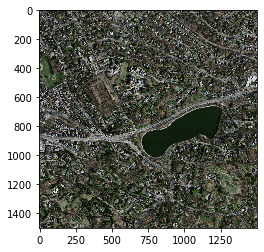

(1500, 1500, 3)


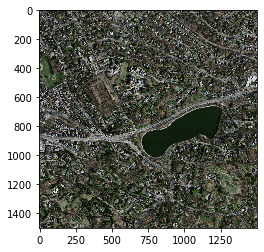

In [11]:
img = np.array(load_img(training_input_data[0]))
plt.imshow(img)
plt.show()
a, b, c, d, e, f ,g, h, i = splitImage(img,(512,512))
merge = mergeImage((a, b, c, d, e, f ,g, h, i), (1500,1500))
print(merge.shape)
plt.imshow(merge)
plt.show()

In [12]:
class ArialDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size * 9,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path)
            img = np.array(img)
            height = img.shape[0]
            width = img.shape[1]
            x[j], x[j+1], x[j+2], x[j+3], x[j+4], x[j+5], x[j+6], x[j+7], x[j+8] = splitImage(img,self.img_size)
#             x[j] = topLeft
#             x[j+1] = topRight
#             x[j+2] = bottomLeft
#             x[j+3] = bottomRight
        y = np.zeros((self.batch_size * 9,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, color_mode="grayscale")
            img = ((np.array(img) / 255)).astype('uint8')
            height = img.shape[0]
            width = img.shape[1]
            a, b, c, d, e, f, g, h, i = splitImage(img,self.img_size)
            y[j] = np.expand_dims(a, 2)
            y[j+1] = np.expand_dims(b, 2)
            y[j+2] = np.expand_dims(c, 2)
            y[j+3] = np.expand_dims(d, 2)
            y[j+4] = np.expand_dims(e, 2)
            y[j+5] = np.expand_dims(f, 2)
            y[j+6] = np.expand_dims(g, 2)
            y[j+7] = np.expand_dims(h, 2)
            y[j+8] = np.expand_dims(i, 2)
        return x, y

In [13]:
X_train, X_val, y_train, y_val = train_test_split(training_input_data, training_output_data, test_size=0.3)

train_gen = ArialDataset(
    1, img_size, X_train, y_train
)
val_gen = ArialDataset(1, img_size, X_val, y_val)

In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("road_crop.{epoch:02d}.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

callbacks = [mode_autosave, lr_reducer, early_stopping]

In [15]:
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
    
keras.backend.clear_session()
model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
model.compile(optimizer = Adam(),
                    loss=bce_jaccard_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle =True,
                  epochs=20, workers=4, use_multiprocessing=True,
                  validation_data = val_gen, 
                  verbose = 1, callbacks=callbacks)

Segmentation Models: using `keras` framework.
Epoch 1/20
504/504 [==============================] - 1266s 3s/step - loss: 0.7344 - iou_score: 0.4150 - val_loss: 0.5324 - val_iou_score: 0.4782
Epoch 2/20
504/504 [==============================] - 1218s 2s/step - loss: 0.5749 - iou_score: 0.5376 - val_loss: 0.4742 - val_iou_score: 0.5231
Epoch 3/20
504/504 [==============================] - 1214s 2s/step - loss: 0.5434 - iou_score: 0.5622 - val_loss: 0.4610 - val_iou_score: 0.5540
Epoch 4/20
504/504 [==============================] - 1212s 2s/step - loss: 0.5246 - iou_score: 0.5774 - val_loss: 0.4767 - val_iou_score: 0.5552
Epoch 5/20
504/504 [==============================] - 1211s 2s/step - loss: 0.5104 - iou_score: 0.5891 - val_loss: 0.4074 - val_iou_score: 0.5664
Epoch 6/20
504/504 [==============================] - 1216s 2s/step - loss: 0.4967 - iou_score: 0.6002 - val_loss: 0.4791 - val_iou_score: 0.5225
Epoch 7/20
504/504 [==============================] - 1216s 2s/step - loss: 0.

In [16]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()

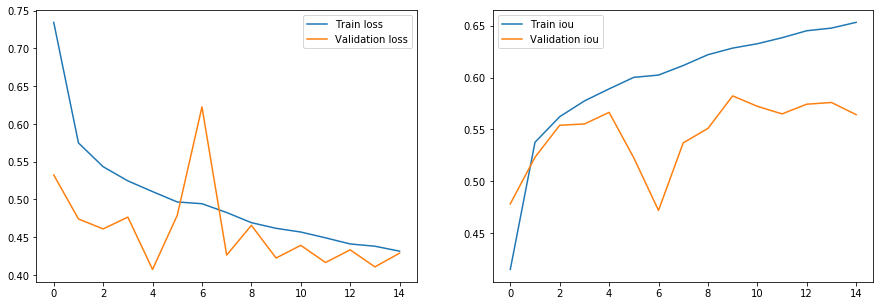

In [17]:
plot_training_history(history)

In [18]:
print(testing_input_data[2])
img = load_img(testing_input_data[2])

road_segmentation_ideal/testing/input/img-13.png


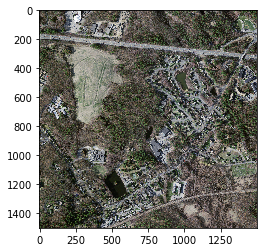

In [19]:
plt.imshow(img)

In [20]:
x = np.zeros((9,) + (512,512) + (3,), dtype="float32")
x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]  = splitImage(np.array(img), (512,512))

In [21]:
output_img = model.predict(x)

In [22]:
output_img.shape

(9, 512, 512, 1)

In [23]:
merge = mergeImage((output_img[0], output_img[1], output_img[2], output_img[3], output_img[4], output_img[5] ,output_img[6], output_img[7], output_img[8]), (1500,1500))

In [24]:
np.unique(merge > 0.5)

array([False,  True])

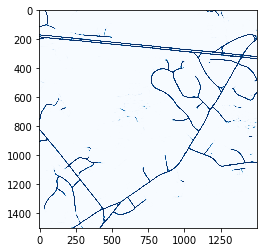

In [25]:
plt.imshow(merge.reshape(1500, 1500), cmap="Blues")

In [1]:
import PIL
from PIL import ImageOps
mask = np.argmax(merge, axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
plt.imshow(img)

NameError: name 'np' is not defined

In [32]:
mask = np.argmax(merge, axis=-1)